In [50]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import PIL
from functools import reduce

In [51]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
INPUT_CHANNELS = 1
import cv2
def path2img(path):
    img = PIL.Image.open(path)
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    return img
def path2imgarray(path, binary=True):
    if INPUT_CHANNELS == 1:
        binary = True
    img = PIL.Image.open(path)
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img)
    
    def binaryzation(img):
        cv_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        return cv_img
    img = binaryzation(img) if binary else img
    img = img / 255.0
    img = img.reshape(IMG_HEIGHT, IMG_WIDTH, (1 if binary else 3) )
    return img

# Model

In [52]:
class AutoEncoder(keras.Model):
    def __init__(self):
        layers = keras.layers
        super().__init__()
        
            
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),# 
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2), # 
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'), # 
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), # 
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same') # 
        ])
        
            
    def call(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)
    def decode(self, x):
        return self.decoder(x)

In [53]:
# Create an instance of the model
autoencoder = AutoEncoder()

trainLoss = tf.keras.metrics.Mean(name='trainLoss')
valLoss = tf.keras.metrics.Mean(name='valLoss')
calLoss = tf.keras.losses.MeanSquaredError()

autoencoder.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS))
autoencoder.summary()
# 查看每一层
for layer in autoencoder.encoder.layers:
    print(layer.name, layer.output_shape)
for layer in autoencoder.decoder.layers:
    print(layer.name, layer.output_shape)

Model: "auto_encoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 32, 32, 8)         1320      
                                                                 
 sequential_9 (Sequential)   (None, 128, 128, 1)       1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________
conv2d_12 (None, 64, 64, 16)
conv2d_13 (None, 32, 32, 8)
conv2d_transpose_8 (None, 64, 64, 8)
conv2d_transpose_9 (None, 128, 128, 16)
conv2d_14 (None, 128, 128, 1)


In [54]:
def getTrainStap(model):
    optimizer = tf.keras.optimizers.Adam()
    @tf.function
    def trainStep(images, labels):
        with tf.GradientTape() as tape:
            predictions = model.encode(images)
            predictions = model.decode(predictions)

            loss = calLoss(labels, predictions)
        # print(loss)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        trainLoss(loss)
    return trainStep
def getValStep(model):
    @tf.function
    def valStep(images, labels):
        predictions = model(images, training=False)
        loss = calLoss(labels, predictions)

        valLoss(loss)
    return valStep

# Data

In [55]:
BATCH_SIZE = 50
trainNoiseDir = './dataset/train/noise/'
trainNoNoiseDir = './dataset/train/noNoise/'
testNoiseDir = './dataset/test/noise/'
testNoNoiseDir = './dataset/test/noNoise/'
# noise 和 noNoise 是输入和标签
dataset = tf.data.Dataset.from_tensor_slices(
    ([path2imgarray(path, binary=False) for path in tf.io.gfile.glob(trainNoiseDir + '*.jpg')], 
    [path2imgarray(path, binary=True) for path in tf.io.gfile.glob(trainNoNoiseDir + '*.jpg')])
)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

valDataset = tf.data.Dataset.from_tensor_slices(
    ([path2imgarray(path, binary=False) for path in tf.io.gfile.glob(testNoiseDir + '*.jpg')],
    [path2imgarray(path, binary=True) for path in tf.io.gfile.glob(testNoNoiseDir + '*.jpg')])
)

valDataset = valDataset.shuffle(buffer_size=1000)
valDataset = valDataset.batch(BATCH_SIZE)
valDataset = valDataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(len(dataset))


14


# Train


Epoch 1, 
Train      Loss: 0.21676619350910187, 
Validation Loss: 0.18719865381717682 - 15.083333333333334 minutes left, 

Epoch 2, 
Train      Loss: 0.12894345819950104, 
Validation Loss: 0.047505736351013184 - 13.466666666666667 minutes left, 

Epoch 3, 
Train      Loss: 0.018378067761659622, 
Validation Loss: 0.00861775316298008 - 13.55 minutes left, 

Epoch 4, 
Train      Loss: 0.009313538670539856, 
Validation Loss: 0.008587654680013657 - 13.066666666666666 minutes left, 

Epoch 5, 
Train      Loss: 0.00932435505092144, 
Validation Loss: 0.008564716205000877 - 13.016666666666667 minutes left, 

Epoch 6, 
Train      Loss: 0.009275740943849087, 
Validation Loss: 0.008469956927001476 - 12.95 minutes left, 

Epoch 7, 
Train      Loss: 0.009022913873195648, 
Validation Loss: 0.008140360936522484 - 12.766666666666667 minutes left, 

Epoch 8, 
Train      Loss: 0.008693772368133068, 
Validation Loss: 0.007911846973001957 - 12.633333333333333 minutes left, 

Epoch 9, 
Train      Loss: 0.0

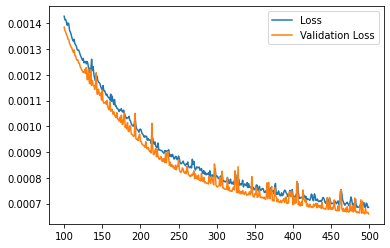

In [56]:
import time,random
# train face1
trainStep = getTrainStap(autoencoder)
valiStep = getValStep(autoencoder)
EPOCHS = 500

lossHistory = []
epochsRange = []

valLossHistory = []

start = time.time()
for epoch in range(EPOCHS):
    trainLoss.reset_states()
    valLoss.reset_states()
        
    for images, labels in dataset:
        trainStep(images, labels)
    
    # random validate
    for images, labels in valDataset.take(10):
        valiStep(images,labels)
        
    


    
    print(
        f'\nEpoch {epoch + 1}, '
        f'\nTrain      Loss: {trainLoss.result()}, '
        f'\nValidation Loss: {valLoss.result()}'
        f' - {int((time.time() - start) / (epoch + 1) * (EPOCHS - epoch)) / 60} minutes left, '
    )
    lossHistory.append(trainLoss.result())
    valLossHistory.append(valLoss.result())
    epochsRange.append(epoch)

plt.plot(epochsRange[100:], lossHistory[100:], label='Loss')
plt.plot(epochsRange[100:], valLossHistory[100:], label='Validation Loss')
# 图例
plt.legend(loc='upper right')
plt.show()


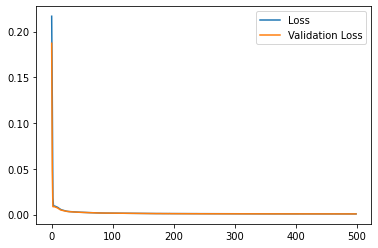

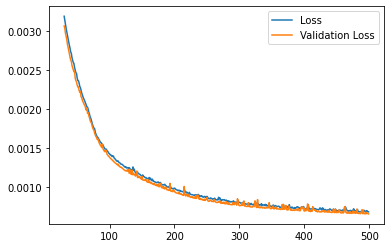

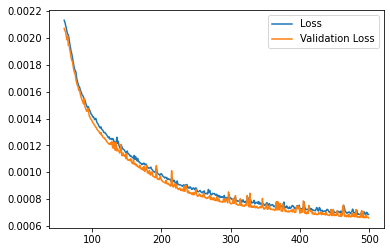

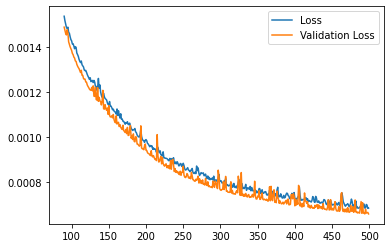

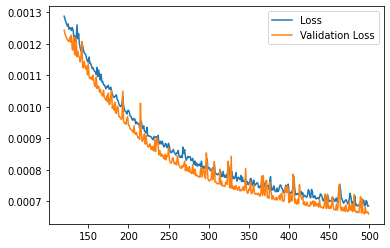

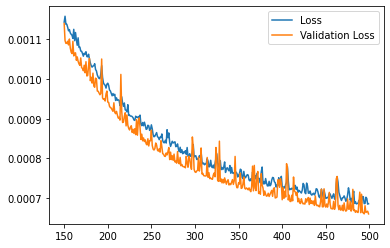

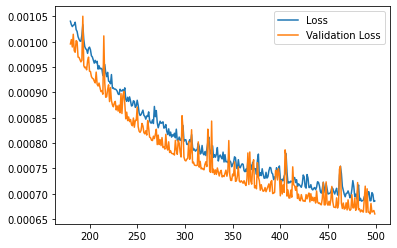

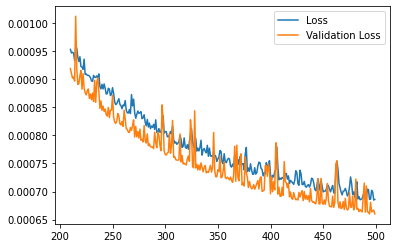

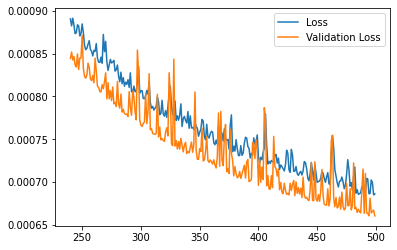

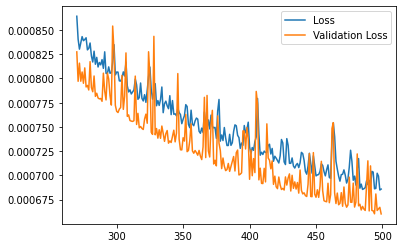

In [61]:
for i in range(10):

  plt.plot(epochsRange[30 * i:], lossHistory[30 * i:], label='Loss')
  plt.plot(epochsRange[30 * i:], valLossHistory[30 * i:], label='Validation Loss')
  # 图例
  plt.legend(loc='upper right')
  plt.show()


In [58]:
autoencoder.save_weights('./captchModel.h5')
#autoencoder.load_weights('./captchModel.h5')

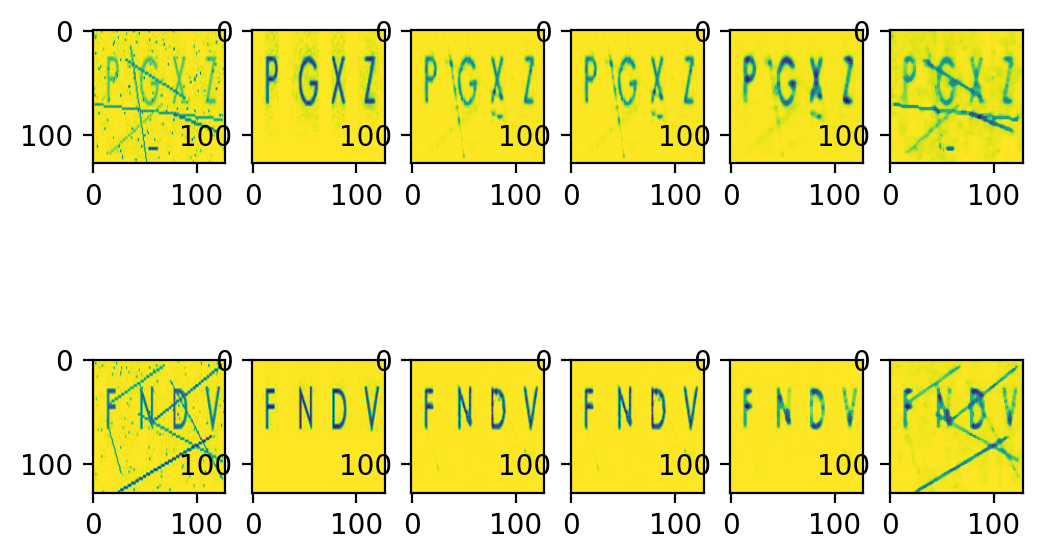

In [64]:
fig,ax = plt.subplots(ncols=6,nrows=2)
fig.dpi = 200
trainData = [*dataset.take(1)][0]
valData = [*valDataset.take(1)][0]
trainInputImg = trainData[0][:1]
trainTargetImg = trainData[1][:1]
valInputImg = valData[0][:1] 
valTargetImg = valData[1][:1]
ax[0][0].imshow(trainInputImg[0])
ax[0][1].imshow(trainTargetImg[0])
ax[0][2].imshow(autoencoder(trainInputImg,training=False)[0])
ax[1][0].imshow(valInputImg[0])
ax[1][1].imshow(valTargetImg[0])
ax[1][2].imshow(autoencoder(valInputImg,training=False)[0])
import cv2
# 二值化
def binaryzation(img):
    cv_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    cv_img = cv2.threshold(cv_img,190,255,cv2.THRESH_BINARY_INV)[1]
    return cv_img
# read img from np float
# float to int
def img2int(img):
    img *= 255
    img = img.astype(np.uint8)
    return img
ax[0][3].imshow(np.array(autoencoder(trainInputImg,training=False)[0]))
ax[1][3].imshow(np.array(autoencoder(valInputImg,training=False)[0]))
# 中值滤波
def medianBlur(img):
    img = cv2.medianBlur(img,5)
    return img
ax[0][4].imshow(medianBlur(np.array(autoencoder(trainInputImg,training=False)[0])))
ax[1][4].imshow(medianBlur(np.array(autoencoder(valInputImg,training=False)[0])))
ax[0][5].imshow(medianBlur(img2int(np.array(trainInputImg[0]))))
ax[1][5].imshow(medianBlur(img2int(np.array(valInputImg[0]))))

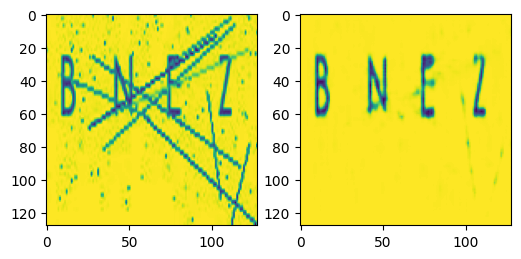

In [60]:
img = path2imgarray('./noise-BNEZ.jpg', binary=True)
img = img.reshape((1,IMG_HEIGHT,IMG_WIDTH,1))
fig,ax = plt.subplots(ncols=2,nrows=1)
fig.dpi = 100
ax[0].imshow(img[0])
ax[1].imshow(
    autoencoder(img,training=False)[0]
)